In [134]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from math import ceil

import numpy as np

# Задача: Добиться от классифкатора на fashionMNIST переобучения за счет изменения архитектуры и гиперпараметров.

### Загрузим датасет

In [2]:
train = datasets.FashionMNIST('../data/FasionMNIST/train', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
test = datasets.FashionMNIST('../data/FasionMNIST/test', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

### Визуализируем несколько картинок

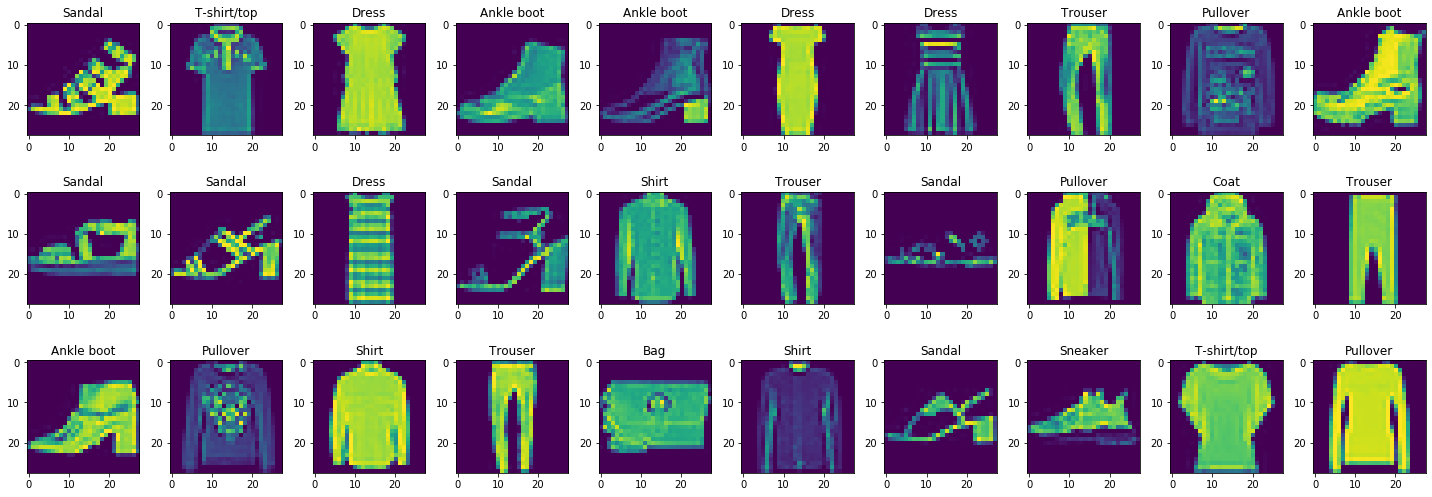

In [112]:
images, labels = next(iter(trainset))

cols = 10
f = plt.figure(figsize=(20, 300))
for i, image in enumerate(images[:30]):
    ax = f.add_subplot(ceil(len(images//cols)), cols, i+1)
    plt.imshow(image.view([28, 28]).numpy())
    ax.set_title(train.classes[labels[i]])   
    
plt.tight_layout()

### Определим простую полносвязную архитектуру нейронной сети

In [6]:
base_neurons_qnt = 128

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1*28*28, base_neurons_qnt)
        self.fc2 = nn.Linear(base_neurons_qnt, base_neurons_qnt)
        self.fc3 = nn.Linear(base_neurons_qnt, base_neurons_qnt)
        self.fc4 = nn.Linear(base_neurons_qnt, 10)
        
    def forward(self, batch):
        batch = F.relu(self.fc1(batch))
        batch = F.relu(self.fc2(batch))
        batch = F.relu(self.fc3(batch))
        batch = F.log_softmax(self.fc4(batch), dim=1)
        
        return batch

In [113]:
def evaluate_accuracy_and_loss(model, testset):
    '''
    Evaluates both model accuracy and loss on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (accuracy, mean loss)
    '''
    correct = 0
    total = 0
    
    loss = 0
    batches = 0

    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.view([-1, 28*28]).cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) == labels[idx]:
                    correct += 1
                total += 1
            loss += F.cross_entropy(output, labels.cuda())
            batches += 1
                
    return correct/total, loss/batches

def get_flaws(model, testset):
    '''
    Evaluates and returns model flaws on a given dataset
    
    model - model to evaluate
    testset - dataset to evaluate model on
    
    Returns tuple (err_images, err_vectors, true_labels, err_labels)
    err_images is an images, misclassified by model
    err_vectors is a vector of log probas, given by a model to a flawed image
    true_labels is a true labels of a flawed images
    err_labels is a labels, that wrongly assigned to an image by model
    '''    

    err_images = []
    err_vectors = []
    true_labels = []
    err_labels = []

    with torch.no_grad():
        for batch in testset:
            images, labels = batch
            output = model(images.view([-1, 28*28]).cuda())            
            for idx, i in enumerate(output):
                if torch.argmax(i) != labels[idx]:
                    err_images.append(images[idx])
                    true_labels.append(int(labels[idx].numpy()))
                    err_labels.append(int(torch.argmax(i).cpu().numpy()))
                    err_vectors.append(i)

    err_labels = [train.classes[e] for e in err_labels]
    true_labels = [train.classes[e] for e in true_labels]
    
    return err_images, err_vectors, true_labels, err_labels

### Натренируем модель

In [115]:
%%time

net = Net().cuda()
adam = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 80

train_acc = []
test_acc = []

train_loss = []
test_loss = []

flaws_15 = None
flaws_80 = None

for epoch in range(EPOCHS):
    for batch in trainset:
        images, labels = batch
        net.zero_grad()
        output = net(images.view(-1, 28*28).cuda())
        loss = F.cross_entropy(output, labels.cuda())
        loss.backward()
        adam.step()
        
    train_acc_, train_loss_ = evaluate_accuracy_and_loss(net, trainset)
    test_acc_, test_loss_ = evaluate_accuracy_and_loss(net, testset)
    
    train_acc.append(train_acc_)
    train_loss.append(train_loss_)
    
    test_acc.append(test_acc_)
    test_loss.append(test_loss_)
    
    print('Epoch {}: train/test acc: {:.3f}/{:.3f} train/test loss: {:.3f}/{:.3f}'.format(epoch+1, train_acc[-1], test_acc[-1], train_loss[-1], test_loss[-1]))
    
    if epoch == 15:
        flaws_15 = get_flaws(net, testset)
        
flaws_80 = get_flaws(net, testset)

Epoch 1: train/test acc: 0.849/0.835 train/test loss: 0.429/0.471
Epoch 2: train/test acc: 0.869/0.858 train/test loss: 0.358/0.400
Epoch 3: train/test acc: 0.881/0.864 train/test loss: 0.325/0.379
Epoch 4: train/test acc: 0.879/0.861 train/test loss: 0.329/0.387
Epoch 5: train/test acc: 0.886/0.865 train/test loss: 0.310/0.367
Epoch 6: train/test acc: 0.897/0.872 train/test loss: 0.278/0.351
Epoch 7: train/test acc: 0.902/0.875 train/test loss: 0.262/0.338
Epoch 8: train/test acc: 0.904/0.878 train/test loss: 0.256/0.340
Epoch 9: train/test acc: 0.909/0.880 train/test loss: 0.241/0.338
Epoch 10: train/test acc: 0.912/0.878 train/test loss: 0.237/0.340
Epoch 11: train/test acc: 0.908/0.878 train/test loss: 0.240/0.339
Epoch 12: train/test acc: 0.918/0.884 train/test loss: 0.219/0.327
Epoch 13: train/test acc: 0.913/0.883 train/test loss: 0.228/0.364
Epoch 14: train/test acc: 0.920/0.883 train/test loss: 0.212/0.336
Epoch 15: train/test acc: 0.922/0.886 train/test loss: 0.203/0.339
Epoc

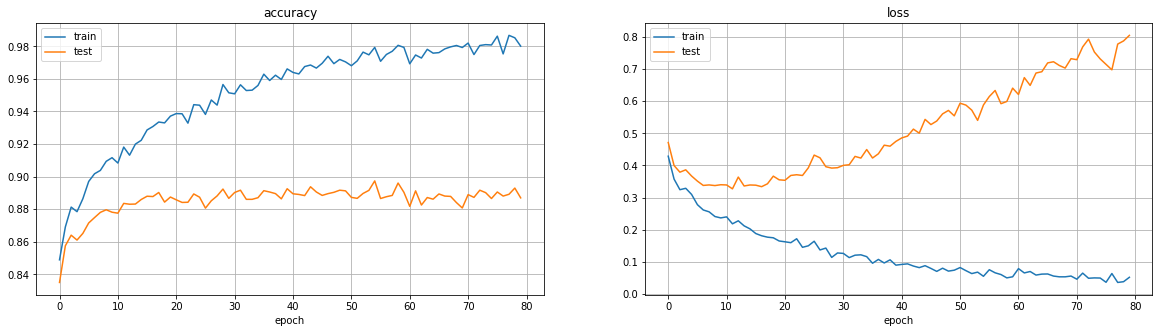

In [116]:
f = plt.figure(figsize=(20, 5))

ax = f.add_subplot(121)
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
plt.grid(True)
plt.legend()

ax = f.add_subplot(122)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
ax.set_title('loss')
ax.set_xlabel('epoch')
plt.grid(True)
plt.legend()

plt.show()

In [118]:
def plot_flaws( err_images, err_vectors, true_labels, err_labels, images_in_row = 5, images_to_sample = 15):
    
    f = plt.figure(figsize=(20, 10))

    images_in_row = 5
    images_to_sample = 15
    random_images = np.random.randint(0, len(err_images), images_to_sample)

    for i, im_idx in enumerate(random_images):
        ax = f.add_subplot(ceil(images_to_sample/images_in_row), images_in_row, i+1)
        plt.imshow(err_images[im_idx].numpy().reshape([28, 28]))
        plt.title('{} recognized as {}\nConfidence: {:.3f}%'.format(true_labels[im_idx], err_labels[im_idx], np.e**err_vectors[im_idx].max()*100))

    plt.tight_layout()

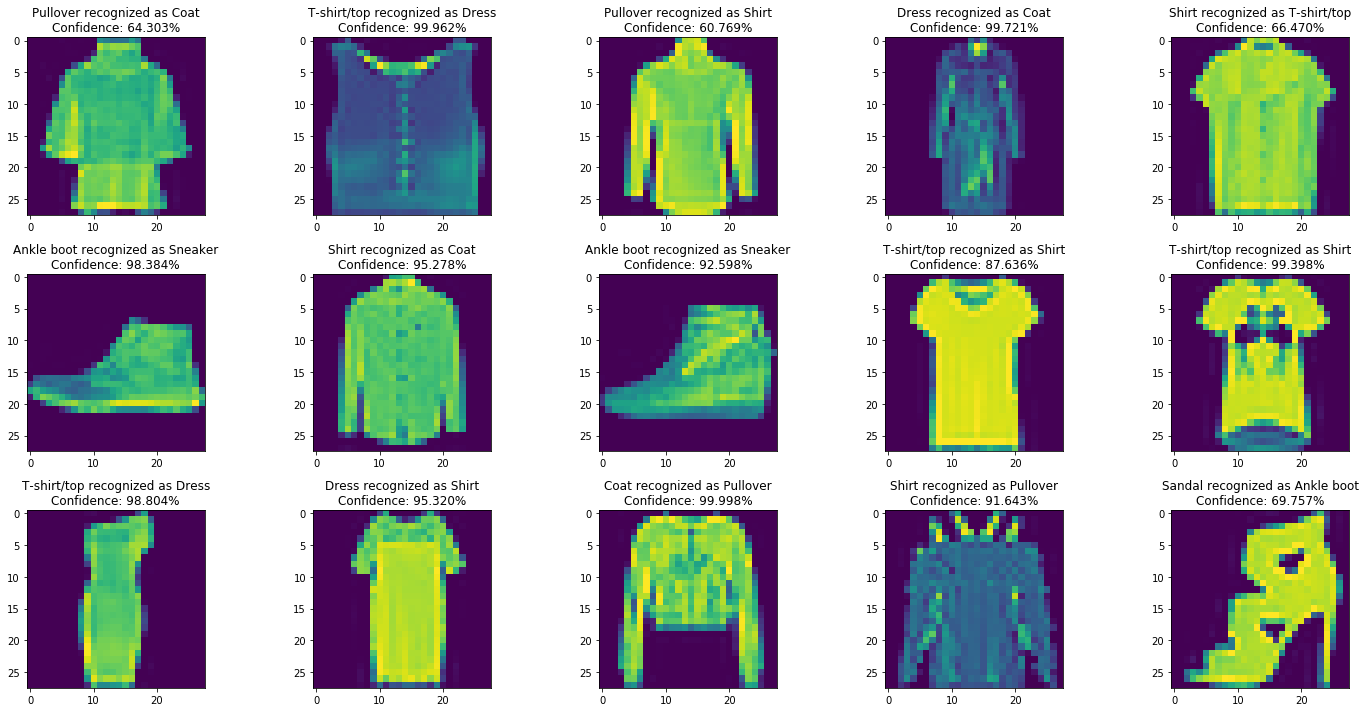

In [119]:
plot_flaws(*flaws_80)

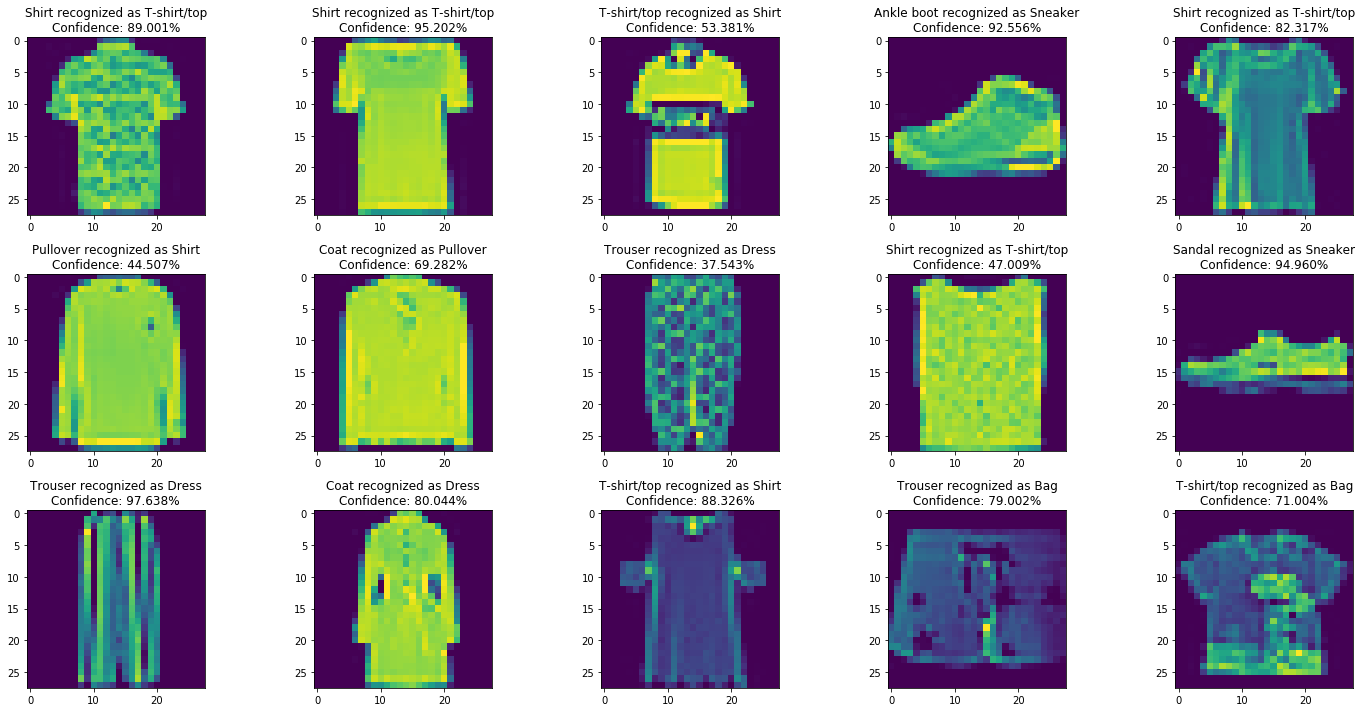

In [120]:
plot_flaws(*flaws_15)

Text(0.5, 0, 'count')

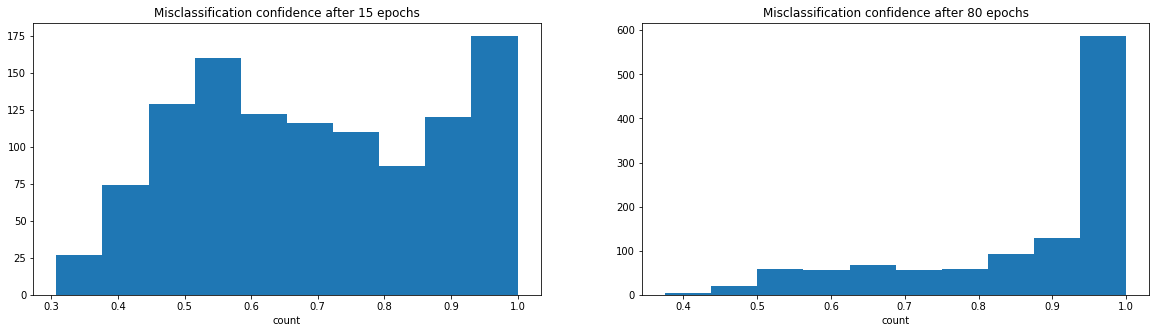

In [153]:
confidense_15 = [np.e**t.cpu().numpy().max() for t in flaws_15[1]]
confidense_80 = [np.e**t.cpu().numpy().max() for t in flaws_80[1]]

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(121)
plt.hist(confidense_15)
ax.set_title('Misclassification confidence after 15 epochs')
ax.set_xlabel('proba')
ax.set_xlabel('count')

ax = f.add_subplot(122)
plt.hist(confidense_80)
ax.set_title('Misclassification confidence after 80 epochs')
ax.set_xlabel('count')

## Вывод: лосс растёт потому, что сеть становится более уверенной в ошибочных ответах. 